In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from os.path import join
from mlsurfacelayer.derived import saturation_mixing_ratio, saturation_vapor_pressure

In [2]:
!which python

/glade/u/home/dgagne/miniconda3/envs/goes/bin/python


In [3]:
#cases_path = "/Users/dgagne/data/cases99/"
cases_path = "/glade/p/cisl/aiml/surface_layer/cases99/"
dates = ["991022", "991023", "991024", "991025"]
cases_xr_data = []

for date in dates:
    cases_xr_data.append(xr.open_dataset(join(cases_path, "cases."+ date + ".nc")))
variables = ["T_5m", "T_15m"]
cases_data = pd.concat([x[variables].to_dataframe() for x in cases_xr_data])

In [5]:
def saturation_vapor_pressure(temperature_K):
    """
    Calculate saturation vapor pressure from Clausius-Clapeyron equation in A First Course in
    Atmospheric Thermodynamics by Grant W. Petty

    Args:
        temperature_K: Temperature in Kelvin

    Returns:
        saturation vapor pressure in hPa/q2//q2
    """
    Rv = 461.0
    T0 = 273.0
    es0 = 6.11
    L = 2.5e6
    return es0 * np.exp(L / Rv * (1 / T0 - 1 / temperature_K))


def saturation_mixing_ratio(temperature_K, pressure_hPa):
    """
    Calculate saturation mixing ratio from temperature and pressure

    Args:
        temperature_K: temperature in Kelvin
        pressure_hPa: pressure in hPA

    Returns:
        saturation mixing ratio in g kg-1
    """
    es = saturation_vapor_pressure(temperature_K)
    epsilon = 0.622
    return epsilon * es / (pressure_hPa - es) * 1000.0


In [6]:
t_2m_cases = pd.concat([x["T_2m"].to_dataframe().unstack() for x in cases_xr_data])
rh_2m_cases = pd.concat([x["RH_2m"].to_dataframe().unstack() for x in cases_xr_data])
p_2m_cases = pd.concat([x["P"].to_dataframe().unstack() for x in cases_xr_data])

In [7]:
qv_2m_cases = pd.DataFrame(rh_2m_cases / 100.0 * saturation_mixing_ratio(t_2m_cases.values + 273, p_2m_cases.values))

In [142]:
qv_2m_cases.loc[cases_data.index >= "1999-10-22-19:00:00"]

RH_2m                                          \
station                  b'1'      b'2'      b'3'      b'4'      b'5'   
time                                                                    
1999-10-22 19:02:30  3.870738  3.986434  3.612406  3.687386  3.872602   
1999-10-22 19:07:30  3.802525  3.961013  3.627841  3.665501  3.876681   
1999-10-22 19:12:30  3.809834  3.951513  3.626724  3.632599  3.936462   
1999-10-22 19:17:30  3.789406  3.904376  3.576814  3.620120  3.827005   
1999-10-22 19:22:30  3.767797  3.932867  3.606702  3.623576  3.834239   
...                       ...       ...       ...       ...       ...   
1999-10-25 23:37:30  5.309615  5.587538  5.265525  5.123889  5.544844   
1999-10-25 23:42:30  5.301398  5.590653  5.297300  5.145299  5.519677   
1999-10-25 23:47:30  5.315557  5.591494  5.394716  5.304229  5.490421   
1999-10-25 23:52:30  5.331979  5.602901  5.459909  5.277904  5.489902   
1999-10-25 23:57:30  5.347332  5.605209  5.462739  5.328264  5.481418   

                               
station                  b'6'  
time                           
1999-10-22 19:02:30  3.807404  
1999-10-22 19:07:30  3.802871  
1999-10-22 19:12:30  3.726689  
1999-10-22 19:17:30  3.764800  
1999-10-22 19:22:30  3.740467  
...                       ...  
1999-10-25 23:37:30  5.304838  
1999-10-25 23:42:30  5.309220  
1999-10-25 23:47:30  5.317492  
1999-10-25 23:52:30  5.388871  
1999-10-25 23:57:30  5.407018  

[924 rows x 6 columns]

In [17]:
cases_vars[cases_vars.str.contains("RH_")]

175     RH_5m
184    RH_15m
187    RH_25m
235    RH_35m
368    RH_45m
371    RH_55m
449     RH_2m
dtype: object

# Hello!
this is documentation

In [28]:
nn_wrf = xr.open_dataset("/glade/work/dgagne/WRF-SCM-Ange_casper/WRF-MLSL/cases99/cabauw_nn/wrfout_d01_1999-10-22_19:00:00")
rf_wrf = xr.open_dataset("/glade/work/dgagne/WRF-SCM-Ange_casper/WRF-MLSL/cases99/cabauw_rf/wrfout_d01_1999-10-22_19:00:00")

most_wrf = xr.open_dataset("/glade/work/dgagne/WRF-SCM-Ange_casper/WRF-MLSL/cases99/most/wrfout_d01_1999-10-22_19:00:00")

In [25]:
times = pd.DatetimeIndex(rf_wrf["Times"].astype(str).str.replace("_", "T"))

In [24]:
pressure = nn_wrf["P"][:, 0, 0, 0] + nn_wrf["PB"][0, 0, 0, 0]


In [22]:
def wrf_temperature(wrf_ds):
    pressure = wrf_ds["P"][1:, 0, 0, 0] + wrf_ds["PB"][1:, 0, 0, 0]
    pot_temp = wrf_ds["T"][1:,0, 0, 0] + 300
    return pot_temp * (pressure / 100000) ** (2.0 / 7.0)

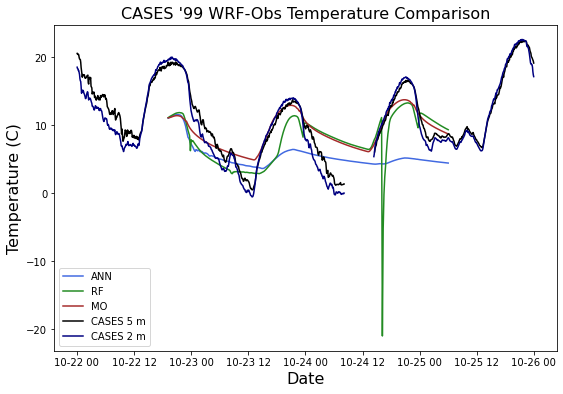

In [31]:
plt.figure(figsize=(9, 6))
plt.plot(times[1:],  wrf_temperature(nn_wrf) - 273, color="royalblue", label="ANN")
plt.plot(times[1:], wrf_temperature(rf_wrf) - 273, color="forestgreen", label="RF")

plt.plot(times[1:], wrf_temperature(most_wrf) - 273, color="brown", label="MO")
plt.plot(cases_data.index, cases_data["T_5m"][:], color="k", label="CASES 5 m")
plt.plot(t_2m_cases.index, t_2m_cases.values.mean(axis=1), color="navy", label="CASES 2 m")
plt.ylabel("Temperature (C)", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.legend()
plt.title("CASES '99 WRF-Obs Temperature Comparison", fontsize=16)
#plt.xlim("1999-10-22T19:00", "1999-10-25T06:00")
plt.savefig("cases_temp_comp.pdf", dpi=200, bbox_inches="tight")

In [7]:
rf_wrf.close()
most_wrf.close()

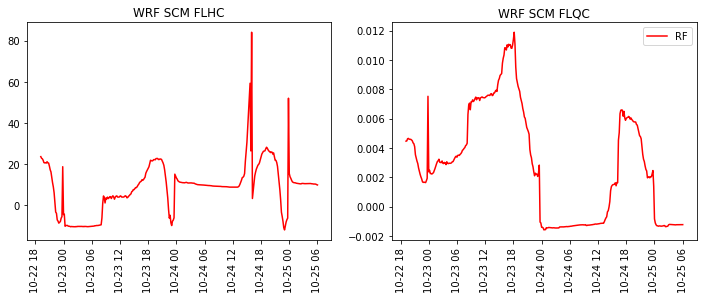

In [15]:
plt.figure(figsize=(12, 4))
time = pd.DatetimeIndex(pd.Series(rf_wrf["Times"][1:].values.astype(str)).str.replace("_", "T"))
plt.subplot(1, 2, 1)
plt.plot(time, rf_wrf["FLHC"][1:, 0, 0], 'r', label="RF")
#plt.plot(time, most_wrf["FLHC"][1:, 0, 0], 'b', label="MO")
plt.title("WRF SCM FLHC")
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
plt.title("WRF SCM FLQC")
plt.plot(time, rf_wrf["FLQC"][1:, 0, 0], 'r', label="RF")
#plt.plot(time, most_wrf["FLQC"][1:, 0, 0], 'b', label="MO")
plt.legend(loc=0)
plt.xticks(rotation=90)
plt.savefig("rf_mo_flhc_flqc.png", dpi=200, bbox_inches="tight")

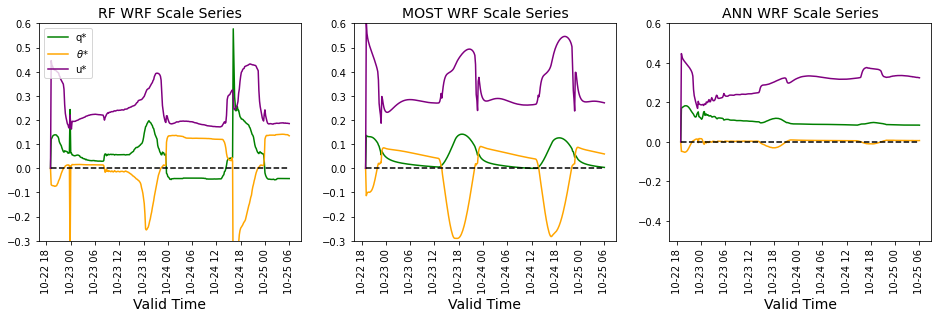

In [34]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
time = pd.DatetimeIndex(pd.Series(rf_wrf["Times"][:].values.astype(str)).str.replace("_", "T"))
plt.plot(time, rf_wrf["QSTAR"][:, 0, 0] * 1000, color="green", label="q*")
plt.plot(time, rf_wrf["MOL"][:, 0, 0], color="orange", label="$\\theta$*")
plt.plot(time, rf_wrf["UST"][:, 0, 0], color="purple", label="u*")
plt.plot(time, np.zeros(rf_wrf["UST"][:, 0, 0].size), 'k--')
plt.xlabel("Valid Time", fontsize=14)
plt.legend(loc=2)

plt.title("RF WRF Scale Series", fontsize=14)
plt.xticks(rotation=90)

plt.ylim(-0.3, 0.6)
plt.subplot(1, 3, 2)
plt.plot(time, most_wrf["QSTAR"][:, 0, 0] * 1000, color="green", label="q*")
plt.plot(time, most_wrf["MOL"][:, 0, 0], color="orange", label="$\\theta$*")
plt.plot(time, most_wrf["UST"][:, 0, 0], color="purple", label="u*")
plt.plot(time, np.zeros(rf_wrf["UST"][:, 0, 0].size), 'k--')
plt.xlabel("Valid Time", fontsize=14)
plt.xticks(rotation=90)
plt.title("MOST WRF Scale Series", fontsize=14)
plt.ylim(-0.3, 0.6)
plt.subplot(1, 3, 3)

plt.plot(time, nn_wrf["QSTAR"][:, 0, 0] * 1000, color="green", label="q*")
plt.plot(time, nn_wrf["MOL"][:, 0, 0], color="orange", label="$\\theta$*")
plt.plot(time, nn_wrf["UST"][:, 0, 0], color="purple", label="u*")
plt.plot(time, np.zeros(rf_wrf["UST"][:, 0, 0].size), 'k--')
plt.xlabel("Valid Time", fontsize=14)
plt.title("ANN WRF Scale Series", fontsize=14)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.6)

plt.savefig("rf_mo_scale_series_nn.png", dpi=200, bbox_inches="tight")



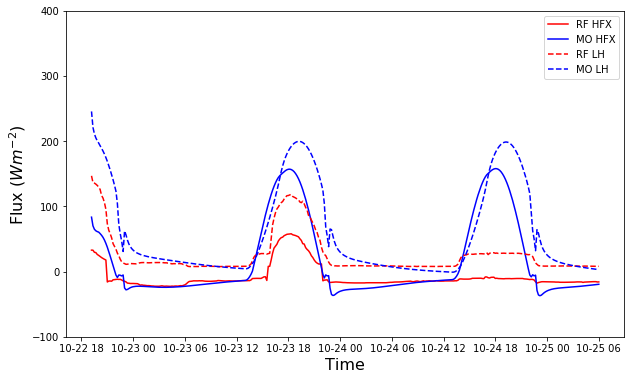

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(rf_wrf["XTIME"][1:], rf_wrf["HFX"][1:, 0, 0], "r-", label="RF HFX")
plt.plot(most_wrf["XTIME"][1:], most_wrf["HFX"][1:, 0, 0], "b-", label="MO HFX")
plt.plot(rf_wrf["XTIME"][1:], rf_wrf["LH"][1:, 0, 0], "r--", label="RF LH")
plt.plot(most_wrf["XTIME"][1:], most_wrf["LH"][1:, 0, 0], "b--", label="MO LH")
plt.legend()
plt.ylim(-100, 400)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Flux ($W m^{-2}$)", fontsize=16)
plt.savefig("wrf_flux_comp_rf17.png", dpi=200, bbox_inches="tight")

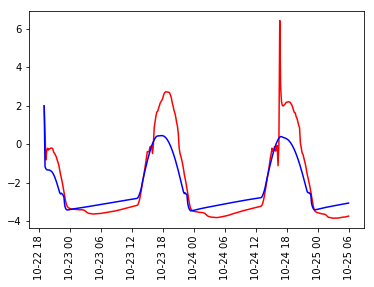

In [12]:
time = pd.DatetimeIndex(pd.Series(rf_wrf["Times"][:].values.astype(str)).str.replace("_", "T"))
plt.plot(time, rf_wrf["TSK"][:, 0, 0] - (rf_wrf["T"][:, 0, 0, 0] + 300), 'r-', label="RF")
plt.plot(time, most_wrf["TSK"][:, 0, 0] - (most_wrf["T"][:, 0, 0, 0] + 300), 'b-', label="MO")
plt.xticks(rotation=90)
plt.savefig("tdiff_comp_rf16.png", dpi=200, bbox_inches="tight")

(119, 355)
(119, 355)
(120, 355)
(59, 355)


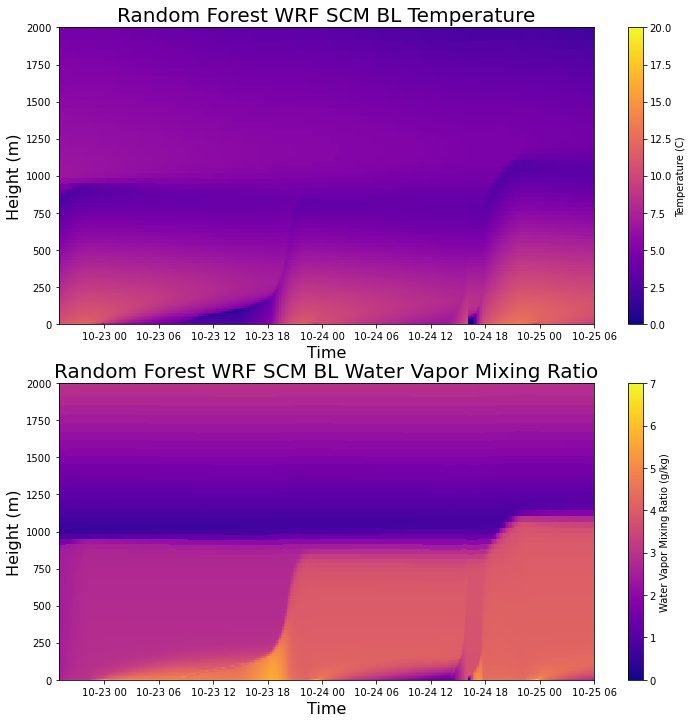

In [35]:
plt.figure(figsize=(12, 12))
pres = (rf_wrf["P"][:, :, 0, 0].T  +rf_wrf["PB"][:, :, 0, 0].T)
height = (rf_wrf["PH"][:, :, 0, 0].T + rf_wrf["PHB"][:, :, 0, 0].T) / 9.81
temperature = ((rf_wrf["T"][:, :, 0, 0].T + 300) * ( pres/ 100000.0) ** (2. / 7.)) - 273
moisture = rf_wrf["QVAPOR"][:, :, 0, 0].T * 1000
wspd = np.sqrt(rf_wrf["U"][:, :, 0, 0].T ** 2 + rf_wrf["V"][:, :, 0, 0].T ** 2)
print(temperature.shape)
print(wspd.shape)
print(height.shape)
time_tile = np.tile(rf_wrf["XTIME"].values.reshape(-1, 1), 59).T
print(time_tile.shape)
plt.subplot(2, 1, 1)
plt.pcolormesh(pd.DatetimeIndex(rf_wrf["XTIME"].values), 
               height, 
               temperature, vmin=0, vmax=20, cmap="plasma")
plt.ylim(0, 2000)
plt.ylabel("Height (m)", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.title("Random Forest WRF SCM BL Temperature", fontsize=20)
plt.colorbar(label="Temperature (C)")
plt.subplot(2, 1, 2)

plt.pcolormesh(pd.DatetimeIndex(rf_wrf["XTIME"].values), 
               height, 
               moisture, vmin=0, vmax=7, label="Water Vapor Mixing Ratio", cmap="plasma")
plt.ylim(0, 2000)
plt.ylabel("Height (m)", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.title("Random Forest WRF SCM BL Water Vapor Mixing Ratio", fontsize=20)
plt.colorbar(label="Water Vapor Mixing Ratio (g/kg)")
plt.savefig("rf_wrf_temp_moisture_rf16.png", dpi=200, bbox_inches="tight")

(119, 355)
(119, 355)
(119, 355)
(59, 355)


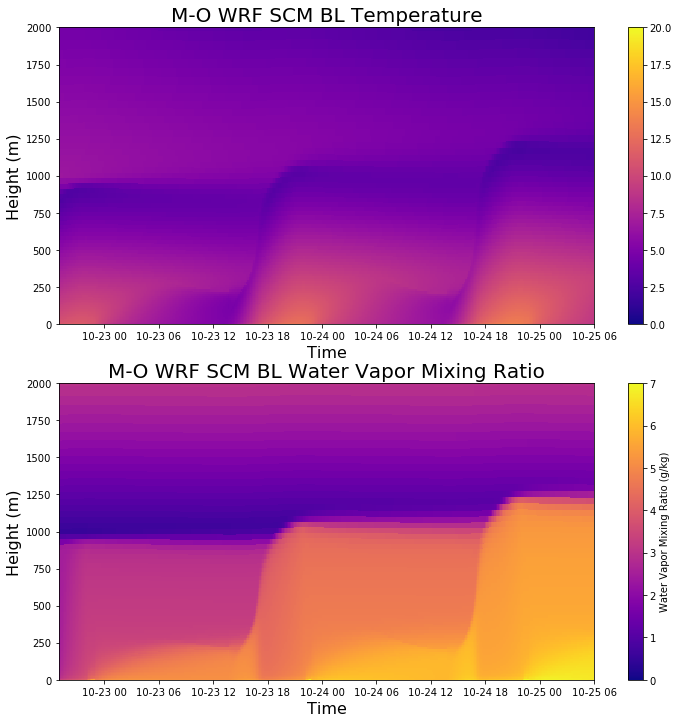

In [11]:
plt.figure(figsize=(12, 12))
pres = (most_wrf["P"][:, :, 0, 0].T  +most_wrf["PB"][:, :, 0, 0].T)
height = (most_wrf["PH"][:, :-1, 0, 0].T + most_wrf["PHB"][:, :-1, 0, 0].T) / 9.81
temperature = ((most_wrf["T"][:, :, 0, 0].T + 300) * ( pres/ 100000.0) ** (2. / 7.)) - 273
moisture = most_wrf["QVAPOR"][:, :, 0, 0].T * 1000
wspd = np.sqrt(most_wrf["U"][:, :, 0, 0].T ** 2 + most_wrf["V"][:, :, 0, 0].T ** 2)
print(temperature.shape)
print(wspd.shape)
print(height.shape)
time_tile = np.tile(rf_wrf["XTIME"].values.reshape(-1, 1), 59).T
print(time_tile.shape)
plt.subplot(2, 1, 1)
plt.pcolormesh(pd.DatetimeIndex(rf_wrf["XTIME"].values), 
               height, 
               temperature, vmin=0, vmax=20, cmap="plasma")
plt.ylim(0, 2000)
plt.ylabel("Height (m)", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.title("M-O WRF SCM BL Temperature", fontsize=20)
plt.colorbar()
plt.subplot(2, 1, 2)

plt.pcolormesh(pd.DatetimeIndex(rf_wrf["XTIME"].values), 
               height, 
               moisture, vmin=0, vmax=7, label="Water Vapor Mixing Ratio", cmap="plasma")
plt.ylim(0, 2000)
plt.ylabel("Height (m)", fontsize=16)
plt.xlabel("Time", fontsize=16)
plt.title("M-O WRF SCM BL Water Vapor Mixing Ratio", fontsize=20)
plt.colorbar(label="Water Vapor Mixing Ratio (g/kg)")
plt.savefig("most_wrf_temp_moisture.png", dpi=200, bbox_inches="tight")


In [49]:
def saturation_vapor_pressure(temperature_K):
    """
    Calculate saturation vapor pressure from Clausius-Clapeyron equation in A First Course in
    Atmospheric Thermodynamics by Grant W. Petty

    Args:
        temperature_K: Temperature in Kelvin

    Returns:
        saturation vapor pressure in hPa
    """
    Rv = 461.0
    T0 = 273.0
    es0 = 6.11
    L = 2.5e6
    return es0 * np.exp(L / Rv * (1 / T0 - 1 / temperature_K))
def saturation_mixing_ratio(temperature_K, pressure_hPa):
    """
    Calculate saturation mixing ratio from temperature and pressure

    Args:
        temperature_K: temperature in Kelvin
        pressure_hPa: pressure in hPA

    Returns:
        saturation mixing ratio in g kg-1
    """
    es = saturation_vapor_pressure(temperature_K)
    epsilon = 0.622
    return epsilon * es / (pressure_hPa - es) * 1000.0

saturation_mixing_ratio(most_wrf["TSK"][5, 0, 0], most_wrf["PSFC"][5, 0, 0] / 100) / 1000


<xarray.DataArray ()>
array(0.009358)
Coordinates:
    XLAT     float32 37.6
    XLONG    float32 -96.7
    XTIME    datetime64[ns] 1999-10-22T19:50:00

(0, 0.003)

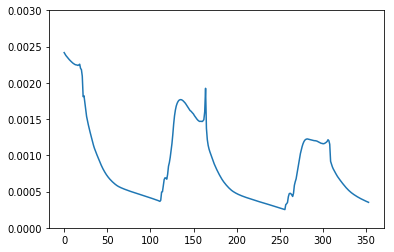

In [15]:
plt.plot(rf_wrf["QVAPOR"][1:, 0, 0, 0].T)
plt.ylim(0, 0.003)

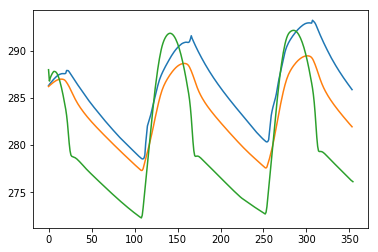

In [12]:
plt.plot(rf_wrf["T"][1:, 0, 0, 0] + 300)
plt.plot(most_wrf["T"][1:, 0, 0, 0] + 300)

#plt.plot(rf_wrf["TH2"][1:,0, 0])
#plt.plot(rf_wrf["T2"][1:, 0, 0])
#plt.plot(rf_wrf["TSK"][0:, 0, 0])
plt.plot(most_wrf["TSK"][0:, 0, 0])


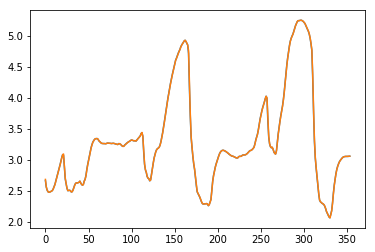

In [11]:
plt.plot(rf_wrf["U"][1:, 0, 0, 0])
plt.plot(rf_wrf["U10"][1:, 0, 0])

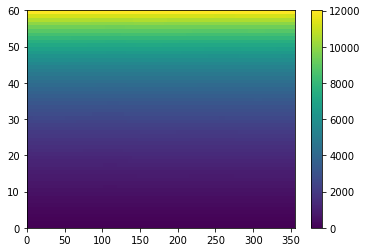

In [6]:
plt.pcolormesh((rf_wrf["PH"][:, :, 0, 0].T + rf_wrf["PHB"][:, :, 0, 0].T) / 9.81)
plt.colorbar()

(200, 310)

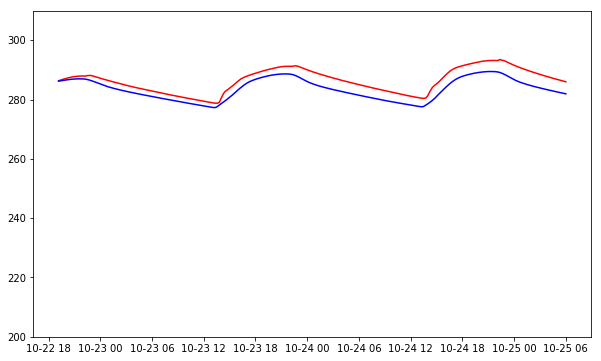

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(pd.DatetimeIndex(rf_wrf["XTIME"].values[1:]), rf_wrf["T"][1:, 0, 0, 0] + 300, 'r-')
plt.plot(pd.DatetimeIndex(most_wrf["XTIME"].values[1:]), most_wrf["T"][1:, 0, 0, 0] + 300, 'b-')
plt.ylim(200, 310)

(0, 5)

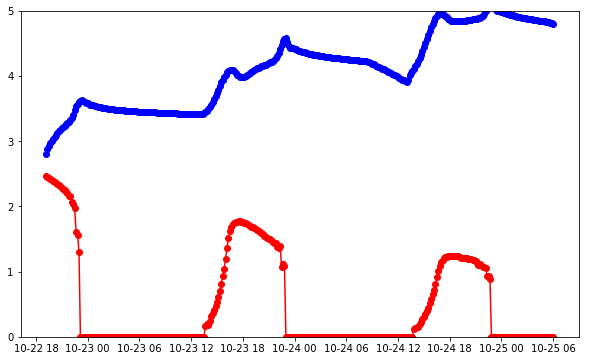

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(pd.DatetimeIndex(rf_wrf["XTIME"].values[1:]), rf_wrf["Q2"][1:, 0, 0] * 1000, 'ro-')
plt.plot(pd.DatetimeIndex(most_wrf["XTIME"].values[1:]), most_wrf["Q2"][1:, 0, 0] * 1000, 'bo-')
plt.ylim(0, 5)

(730049.7986111111, 730052.25)

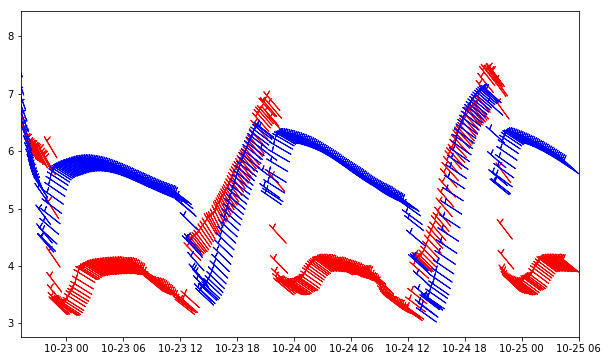

In [12]:
rf_wspd = np.sqrt(rf_wrf["U"][1:, 0, 0, 0] ** 2 + rf_wrf["V"][1:, 0, 0, 0] ** 2)
most_wspd = np.sqrt(most_wrf["U"][1:, 0, 0, 0] ** 2 + most_wrf["V"][1:, 0, 0, 0] ** 2)
times = pd.DatetimeIndex(most_wrf["XTIME"].values[1:])
plt.figure(figsize=(10, 6))
plt.barbs(times, rf_wspd, 
          rf_wrf["U10"][1:, 0, 0], rf_wrf["V10"][1:, 0, 0], color='r')
plt.barbs(times, most_wspd, 
          most_wrf["U10"][1:, 0, 0], most_wrf["V10"][1:, 0, 0], color='b')
plt.xlim(times.min(), times.max())

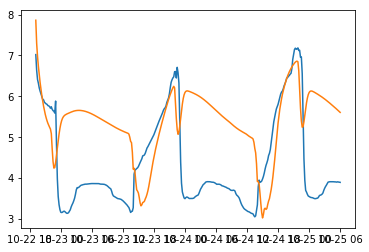

In [13]:
plt.plot(times, np.sqrt(rf_wrf["U"][1:,0, 0, 0] ** 2 + rf_wrf["V"][1:,0, 0, 0] ** 2 ))
plt.plot(times, np.sqrt(most_wrf["U"][1:,0, 0, 0] ** 2 + most_wrf["V"][1:,0, 0, 0] ** 2 ))

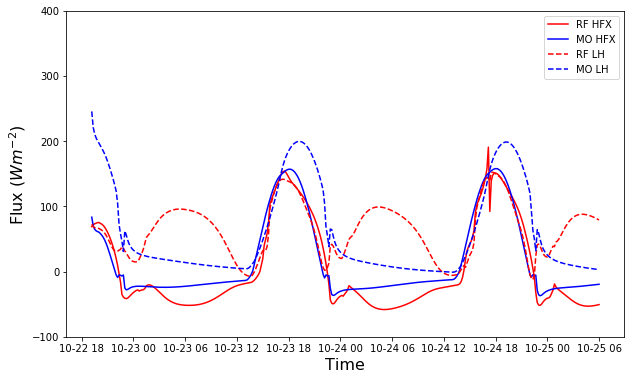

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(rf_wrf["XTIME"][1:], rf_wrf["HFX"][1:, 0, 0], "r-", label="RF HFX")
plt.plot(most_wrf["XTIME"][1:], most_wrf["HFX"][1:, 0, 0], "b-", label="MO HFX")
plt.plot(rf_wrf["XTIME"][1:], rf_wrf["LH"][1:, 0, 0], "r--", label="RF LH")
plt.plot(most_wrf["XTIME"][1:], most_wrf["LH"][1:, 0, 0], "b--", label="MO LH")
plt.legend()
plt.ylim(-100, 400)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Flux ($W m^{-2}$)", fontsize=16)
plt.savefig("wrf_flux_comp.png", dpi=200, bbox_inches="tight")

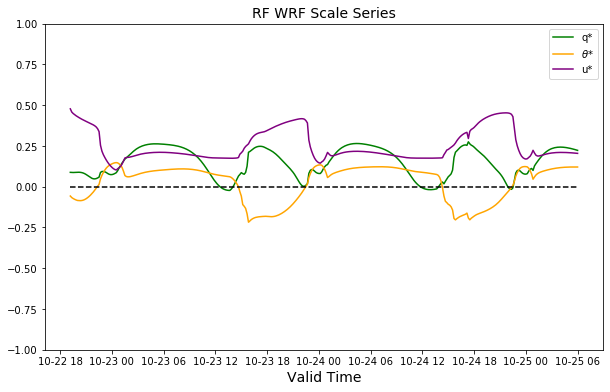

In [14]:
plt.figure(figsize=(10, 6))
time = pd.DatetimeIndex(pd.Series(rf_wrf["Times"][1:].values.astype(str)).str.replace("_", "T"))
plt.plot(time, rf_wrf["QSTAR"][1:, 0, 0] * 1000, color="green", label="q*")
plt.plot(time, rf_wrf["MOL"][1:, 0, 0], color="orange", label="$\\theta$*")
plt.plot(time, rf_wrf["UST"][1:, 0, 0], color="purple", label="u*")
plt.plot(time, np.zeros(rf_wrf["UST"][1:, 0, 0].size), 'k--')
plt.xlabel("Valid Time", fontsize=14)
plt.title("RF WRF Scale Series", fontsize=14)
plt.legend(loc=0)
plt.ylim(-1, 1)
plt.savefig("rf_scale_series.png", dpi=200, bbox_inches="tight")

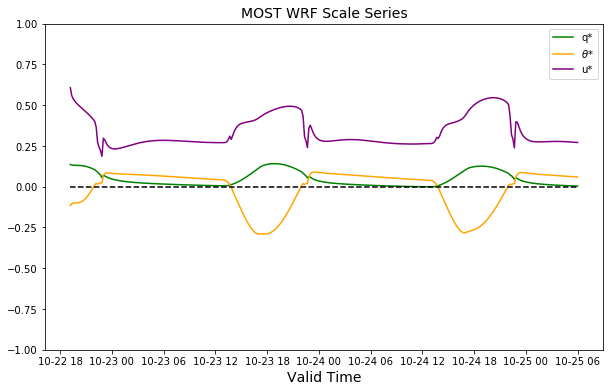

In [13]:
plt.figure(figsize=(10, 6))
time = pd.DatetimeIndex(pd.Series(most_wrf["Times"][1:].values.astype(str)).str.replace("_", "T"))
plt.plot(time, most_wrf["QSTAR"][1:, 0, 0] * 1000, color="green", label="q*")
plt.plot(time, most_wrf["MOL"][1:, 0, 0], color="orange", label="$\\theta$*")
plt.plot(time, most_wrf["UST"][1:, 0, 0], color="purple", label="u*")
plt.plot(time, np.zeros(rf_wrf["UST"][1:, 0, 0].size), 'k--')
plt.xlabel("Valid Time", fontsize=14)
plt.title("MOST WRF Scale Series", fontsize=14)
plt.legend(loc=0)
plt.ylim(-1, 1)
plt.savefig("most_scale_series.png", dpi=200, bbox_inches="tight")

In [31]:
chs_rf = pd.read_csv("../../data/wrf_ml_surface/chs_rf.tbl",delim_whitespace=True, header=None)
chs_mo = pd.read_csv("../../data/wrf_ml_surface/chs_most.tbl",delim_whitespace=True, header=None)


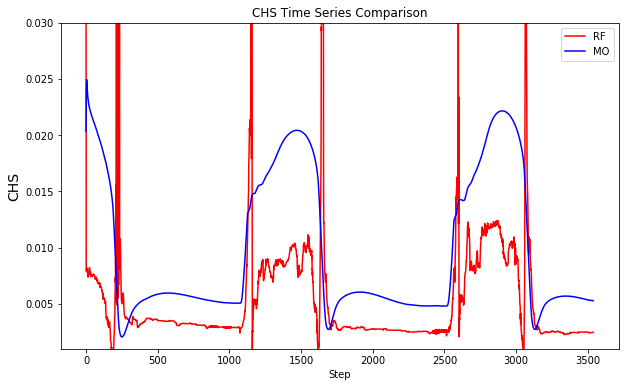

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(chs_rf[2], color="red", label="RF")
plt.plot(chs_mo[2], color="blue", label="MO")
plt.ylim(0.001, 0.03)
plt.ylabel("CHS", fontsize=14)
plt.xlabel("Step")
plt.legend()
plt.title("CHS Time Series Comparison")
plt.savefig("chs_ts.png", bbox_inches="tight")
#plt.gca().set_yscale("log")

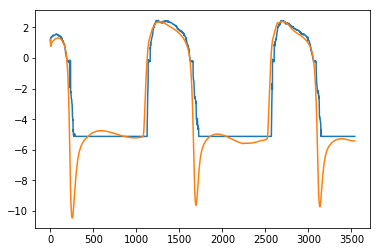

In [37]:
plt.plot(chs_rf[3])
plt.plot(chs_mo[3])

(-10, 25)

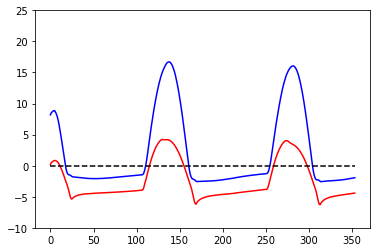

In [7]:
t_diff = most_wrf["TSK"][1:, 0, 0] - (most_wrf["T"][1:, 0, 0, 0] + 300)
sh = most_wrf["HFX"][1:, 0, 0]
plt.plot(t_diff, 'r-')
plt.plot(sh / 10, 'b-')
plt.plot(np.arange(sh.size), np.zeros(sh.size), 'k--')
plt.ylim(-10, 25)

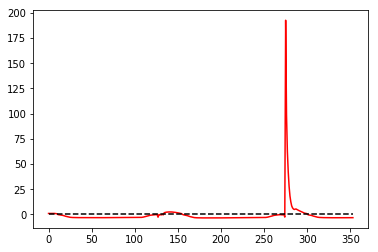

In [10]:
t_diff = rf_wrf["TSK"][1:, 0, 0] - (rf_wrf["T"][1:, 0, 0, 0] + 300)
sh = rf_wrf["HFX"][1:, 0, 0]
plt.plot(t_diff, 'r-')
#plt.plot(sh / 10, 'b-')
plt.plot(np.arange(sh.size), np.zeros(sh.size), 'k--')

#plt.ylim(-10, 25)